In [37]:
from joblib import Parallel, delayed
import joblib
from joblib import Parallel, delayed
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
import numpy as np
import ast
import networkx as nx

In [38]:
def readData():
    try:
        authors = pd.read_csv('data/authors.csv')
    except:
        print('Not found authors.csv')
        authors = None
    try:
        papers = pd.read_csv('data/papers.csv')
    except:
        print('Not found papers.csv')
        papers = None
    try:
        abstracts = pd.read_csv('data/abstracts.csv')
    except:
        print('Not found abstracts.csv')
        abstracts = None
    return authors, papers, abstracts 

# Week 1 - Obtain authors

In [39]:
def getSoup(url, base_url = "https://ic2s2-2023.org"):
    COMPLETE_LINK = base_url+url
    r = requests.get(COMPLETE_LINK)
    return BeautifulSoup(r.content)

In [40]:
soup = getSoup("/program")
sect = soup.find_all("section", attrs = {"id": "main"})
authorsList = set()

for sect in sect:
    for ul in sect.find_all('ul'):
        for li in ul.find_all('li'):
            authors = li.find("i")
            authors = authors.text.split(",")
            authors = [author.strip() for author in authors]
            authorsList.update(authors)


In [41]:
sect = soup.find_all("section", attrs = {"id": "main"})
for sect in sect:
    for h2 in sect.find_all('h2'):
        if "Chair" in h2.text:
            author = h2.text.split("Chair:")[1].strip()
            authorsList.add(author)

In [42]:
# Optional: get the program committee
soup = getSoup("/program_committee")
sect = soup.find_all("section", attrs = {"id": "main"})
for li in sect[0].find_all('li'):
    authors = li.find("b")
    authorsList.update(authors)


In [43]:
# Optional: get the tutorials teachers

soup = getSoup("/tutorials")
sect = soup.find_all("section", attrs = {"id": "highlights"})
sect = sect[1].find_all("div",attrs = {"class":"container"})[0]
for ul in sect.find_all('ul'):
    for b in ul.find_all('b'):
        for a in b.find_all('a'):
            author = a.text    
            authorsList.add(author)

KeyboardInterrupt: 

In [ ]:
print("There is a total of", len(authorsList), "authors")

There is a total of 1649 authors


In [ ]:
with open('data/authorsList.txt', 'w') as file:
    for author in authorsList:
        file.write(author + '\n')

# Week 2 - Obtain author frm OpenAlex

In [ ]:
def defineURL(type):
    BASE_URL = 'https://api.openalex.org/'
    return BASE_URL + type

In [ ]:
with open('data/authorsList.txt', 'r') as file:
    authors_list = file.read().splitlines()

print(authors_list[0:5])

['NAKAO Ran', 'Benjamin Frank Maier', 'Juniper L Lovato', 'Marjolijn Das', 'Vincenzo Nicosia']


In [ ]:
URL_W = defineURL('authors')
selected_vars = 'id,display_name,works_count,works_api_url,summary_stats,last_known_institution'

response = requests.get(URL_W, params={'filter': 'display_name.search:(' + '|'.join(authors_list[0:0+20]) + ')',
                                               'select': selected_vars, 'per-page': '200', 'page': str(1)}).json()

In [44]:
def fetch_results_authors(initial_author):
    URL_W = defineURL('authors')
    selected_vars = 'id,display_name,works_count,works_api_url,summary_stats,last_known_institution'
    i = 1
    def_results = []
    finish = False
    while not finish:
        response = requests.get(URL_W, params={'filter': 'display_name.search:(' + '|'.join(authors_list[initial_author:initial_author+20]) + ')',
                                               'select': selected_vars, 'per-page': '200', 'page': str(i)})
        if response.status_code != 200:
            print('Error at page ' + str(i), 'for authors ' + str(initial_author) + ' to ' + str(initial_author+20), 'and status code ' + str(response.status_code))
            i += 1
        else:
            response = response.json()
            if len(response['results']) == 0:
                finish = True
                break
            def_results += response['results']
            i += 1
    return def_results

initial_authors_range = range(0, len(authors_list), 20)

results = Parallel(n_jobs=-1)(delayed(fetch_results_authors)(initial_author) for initial_author in initial_authors_range)
def_results_authors = [result for sublist in results for result in sublist]

for resp in def_results_authors:
    try:
        resp['country_code'] = resp['last_known_institution']['country_code']
    except:
        resp['country_code'] = np.nan
    try:
        resp['h_index'] = resp['summary_stats']['h_index']
    except:
        resp['h_index'] = 0


print(len(def_results_authors))


40085


In [45]:
authors = pd.DataFrame(def_results_authors, columns = ['id', 'display_name', 'works_count', 'works_api_url','h_index','country_code'])
authors.sample(10)

,id,display_name,works_count,works_api_url,h_index,country_code
29938,https://openalex.org/A5015366132,Zhagn Yan-xia,1,https://api.openalex.org/works?filter=author.i...,0,NaN
33165,https://openalex.org/A5070502098,Marcelo Batista da Silva,1,https://api.openalex.org/works?filter=author.i...,0,NaN
35872,https://openalex.org/A5081625191,Aaron Kyle Smith,1,https://api.openalex.org/works?filter=author.i...,0,NaN
3347,https://openalex.org/A5000665082,Laura Nelson-Hamilton,1,https://api.openalex.org/works?filter=author.i...,0,NaN
2039,https://openalex.org/A5089346134,Yang Li-zhang,1,https://api.openalex.org/works?filter=author.i...,0,NaN
8870,https://openalex.org/A5019426554,Min hui Wang,1,https://api.openalex.org/works?filter=author.i...,0,NaN
34928,https://openalex.org/A5084103089,Muhammad Ashraf Ali Awan,1,https://api.openalex.org/works?filter=author.i...,1,NaN
36140,https://openalex.org/A5092219487,Ali Muhammad Faadhil,1,https://api.openalex.org/works?filter=author.i...,0,NaN
862,https://openalex.org/A5090525851,Zhang Li-bi,32,https://api.openalex.org/works?filter=author.i...,9,CN
38930,https://openalex.org/A5027387902,José Antonio de Vera Lima,1,https://api.openalex.org/works?filter=author.i...,0,NaN


#### Let's delte repited authors
- We first delete all the repited id. (Not necessary any ordering because all the rows are exactly the same)
- Later we delete all the repited display_name. (We order by h_index and delete the lowest one)

In [67]:
authors = authors.drop_duplicates(subset = 'id')

In [76]:
print(authors[authors.display_name.duplicated(keep=False)].sort_values(by='display_name').head(6))
authors = authors.sort_values(by='h_index', ascending=False).drop_duplicates(subset ='display_name',keep='first')

Empty DataFrame
Columns: [id, display_name, works_count, works_api_url, h_index, country_code]
Index: []


In [77]:
authors.to_csv('data/authors.csv', index=False)

In [82]:
authors.sort_values(by='display_name')[10:30]

,id,display_name,works_count,works_api_url,h_index,country_code
24980,https://openalex.org/A5069892661,A L de Castro Mario,2,https://api.openalex.org/works?filter=author.i...,0,NaN
3454,https://openalex.org/A5085785026,A Lee Edward,1,https://api.openalex.org/works?filter=author.i...,0,NaN
32200,https://openalex.org/A5085057017,A Marcelo Silva,1,https://api.openalex.org/works?filter=author.i...,1,NaN
33562,https://openalex.org/A5031371388,A Pereira-Da-Silva Marcelo,1,https://api.openalex.org/works?filter=author.i...,0,NaN
33803,https://openalex.org/A5008413061,A Pereira-da-Silva Marcelo,4,https://api.openalex.org/works?filter=author.i...,0,NaN
25290,https://openalex.org/A5060850928,A Smirnov Ivan,1,https://api.openalex.org/works?filter=author.i...,0,NaN
39818,https://openalex.org/A5049430109,A Yassin Ali,2,https://api.openalex.org/works?filter=author.i...,0,NaN
4094,https://openalex.org/A5068241926,A nne-Marie Urban,1,https://api.openalex.org/works?filter=author.i...,0,NaN
22016,https://openalex.org/A5024453252,A-Li Liao,2,https://api.openalex.org/works?filter=author.i...,0,CN
28825,https://openalex.org/A5019896488,A-Yang Wang,2,https://api.openalex.org/works?filter=author.i...,1,CN


# Week 3 - Searching works

In [ ]:
authors = pd.read_csv('data/authors.csv')
print(authors.shape)

(37350, 6)


In [ ]:
# Get only those authors with more than 5 works and less than 5000
id_list = authors[(authors['works_count'] > 5)  & (authors['works_count']<5000)]['id'].tolist()
print("There are", len(id_list), "authors with more than 5 works and less than 5000")

There are 6180 authors with more than 5 works and less than 5000


In [ ]:
from joblib import Parallel, delayed
# Define a function to fetch results for a given range of initial authors
def fetch_results(initial_author):
    URL_W = defineURL('works')
    selected_vars = 'id,publication_year,cited_by_count,title,abstract_inverted_index,authorships'
    i = 1
    def_results = []
    finish = False
    while not finish:
        response = requests.get(URL_W, params={'filter': 'authorships.author.id:(' + '|'.join(id_list[initial_author:initial_author+20]) + '),cited_by_count:>10,authors_count:<10',
                                               'select': selected_vars, 'per-page': '200', 'page': str(i)})
        if response.status_code != 200:
            print('Error at page ' + str(i), 'for authors ' + str(initial_author) + ' to ' + str(initial_author+20), 'and status code ' + str(response.status_code))
            i += 1
        else:
            response = response.json()
            if len(response['results']) == 0:
                finish = True
                break
            def_results += response['results']
            i += 1
    return def_results

# Define the range of initial authors
initial_authors_range = range(0, len(id_list), 20)

# Parallelize the loop using joblib
results = Parallel(n_jobs=-1)(delayed(fetch_results)(initial_author) for initial_author in initial_authors_range)

# Flatten the results list
def_results_works = [result for sublist in results for result in sublist]

for resp in def_results_works:
    resp['author_id'] = [author['author']['id'] for author in resp['authorships']]
    del resp['authorships']

print('Total of works:', len(def_results_works))

Total of works: 59787


In [ ]:
papers = pd.DataFrame(def_results_works, columns = ['id','publication_year','cited_by_count','title'])
abstracts = pd.DataFrame(def_results_works, columns = ['id','author_id','abstract_inverted_index'])

In [ ]:
papers.to_csv('data/papers.csv', index = False)
abstracts.to_csv('data/abstracts.csv', index = False)

---

In [ ]:
authors = pd.read_csv('data/authors.csv')
papers = pd.read_csv('data/papers.csv')
abstracts = pd.read_csv('data/abstracts.csv')

In [ ]:
(abstracts.iloc[59783]['author_id'])

"['https://openalex.org/A5020724400', 'https://openalex.org/A5035774267', 'https://openalex.org/A5003963130', 'https://openalex.org/A5064614154', 'https://openalex.org/A5030034684', 'https://openalex.org/A5068784832', 'https://openalex.org/A5005626540', 'https://openalex.org/A5017763219']"

In [ ]:
abstracts['author_id']

In [ ]:
abstracts['a'] = abstracts['author_id'].apply(lambda x: len(x))

In [ ]:
hist, edges = np.histogram(author['works_count'],bins = 10)
x = (edges[1:] + edges[:-1])/2

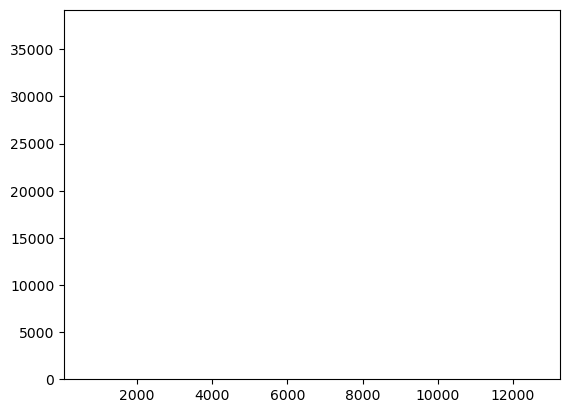

In [ ]:
fig, ax = plt.subplots()
ax.bar(x,hist)

plt.show()

In [ ]:
top5_countries = authors['country_code'].value_counts()[0:5].index

In [ ]:
colors = ['b','g','r','c','m']
fig, ax = plt.subplots()
for country in top5_countries:
    #plot the histogram

SyntaxError: incomplete input (1843980113.py, line 4)

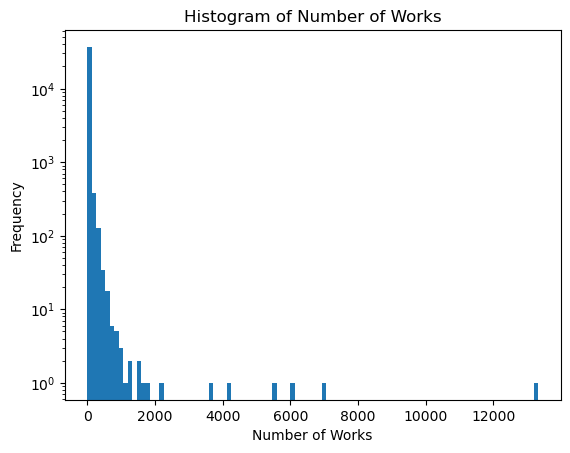

In [ ]:
plt.hist(authors['works_count'], bins=100,log=True, )
plt.xlabel('Number of Works')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Works')
plt.show()


In [ ]:
authors['works_count'].describe()

count    37350.000000
mean        10.803507
std        103.298713
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max      13319.000000
Name: works_count, dtype: float64

---

# Week 4

In [ ]:
authors, papers, abstracts = readData()

In [ ]:
abstracts['author_id'] = abstracts['author_id'].apply(lambda x: ast.literal_eval(x))

In [ ]:
weighted_edgelist = {}

for authors in abstracts['author_id']:
    for i in range(len(authors)):
        for j in range(i+1, len(authors)):
            pair = tuple(sorted([authors[i], authors[j]]))
            if pair in weighted_edgelist:
                weighted_edgelist[pair] += 1
            else:
                weighted_edgelist[pair] = 1

weighted_edgelist = [(pair[0], pair[1], count) for pair, count in weighted_edgelist.items()]


In [ ]:

G = nx.Graph()
G.add_weighted_edges_from(weighted_edgelist)


In [ ]:
authors.loc[authors['id'] == "https://openalex.org/A5055710645", 'display_name']

Series([], Name: display_name, dtype: object)

In [ ]:
for node in G.nodes():
    print(node)
    print(authors.loc[authors['id'] == str(node), 'display_name'])
    break

https://openalex.org/A5055710645
Series([], Name: display_name, dtype: object)


In [ ]:
for node in G.nodes():
    # Retrieve the author's display name, country, citation count, and year of first publication
    display_name = authors.loc[authors['id'] == node, 'display_name']
    country = authors.loc[authors['id'] == node, 'country_code']
    citation_count = authors.loc[authors['id'] == node, 'works_count']
    # first_publication_year = papers.loc[papers['author_id'].apply(lambda x: node in ast.literal_eval(x)), 'publication_year'].min()
    
    # Add the attributes to the node
    G.nodes[node]['display_name'] = display_name
    G.nodes[node]['country'] = country
    G.nodes[node]['citation_count'] = citation_count
    # G.nodes[node]['first_publication_year'] = first_publication_year

# Save the network as a JSON file
nx.write_adjlist(G, './data/network.json')


AttributeError: 'list' object has no attribute 'loc'

In [ ]:
authors.loc[authors['id'] == 'https://openalex.org/A5034987547'	, 'display_name'].values[0]

'Chu-Zhen Xu'

In [ ]:
authors.loc[authors['id'] == 'https://openalex.org/A5034987547', 'country_code'].values[0]

In [ ]:
authors.head()

,id,display_name,works_count,works_api_url,h_index,country_code
0,https://openalex.org/A5034987547,Chu-Zhen Xu,1,https://api.openalex.org/works?filter=author.i...,NaN,CN
1,https://openalex.org/A5037395676,Bian Zhen-xu,1,https://api.openalex.org/works?filter=author.i...,NaN,CN
2,https://openalex.org/A5082004021,José Antonio Rojas García,8,https://api.openalex.org/works?filter=author.i...,NaN,NaN
3,https://openalex.org/A5050248059,Zhang Zhen Xu Zhishi,1,https://api.openalex.org/works?filter=author.i...,NaN,NaN
4,https://openalex.org/A5084863762,Guo Zhen Xu Dezhi,1,https://api.openalex.org/works?filter=author.i...,NaN,NaN
